# Combining Census Data with County Data

First, we need to make sure we are in the root directory of the project to import custom modules. These notebooks are stored in `notebooks/` for cleanliness.

In [1]:
pwd

'/Users/DanOvadia/Projects/covid-hotspots/notebooks'

In [2]:
cd ..

/Users/DanOvadia/Projects/covid-hotspots


### Python Libraries

In [3]:
# To hold and manipulate data
import pandas as pd

# To check across all dates for data accuracy
from datetime import date, timedelta

### Custom Modules

In [4]:
from modules import data_processing
from modules import plotting # not needed, but available

# Extension to auto reload custom modules
%load_ext autoreload

%autoreload 1

%aimport modules.data_processing
%aimport modules.plotting

## Data Importing

### County Coronavirus Data
We import data from [New York Times GitHub](https://github.com/nytimes/covid-19-data) to get county level coronavirus data.

In [149]:
%%time
# Get county data
COVID_COUNTIES_DF = data_processing.get_covid_county_data()

Retrieving Covid County data
Pulling county data from file.
CPU times: user 11.7 s, sys: 1.63 s, total: 13.3 s
Wall time: 18.9 s


In [93]:
# Take a look at columns for reference and context
COVID_COUNTIES_DF.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'log_deaths',
       'log_cases', 'SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY',
       'STNAME', 'CTYNAME', 'POPESTIMATE2019', 'CENSUS2010POP', 'FIPS',
       'casesPerMillion', 'deathsPerMillion', 'case_diff', 'death_diff'],
      dtype='object')

### County Census Data

We import data from census.gov to get county level population data. Specifically using 2019 estimates.

In [7]:
# Get Census Data
CENSUS_COUNTIES_DF = data_processing.get_census_county_data()

In [8]:
# Take a look at columns for reference and context
CENSUS_COUNTIES_DF.columns

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'POPESTIMATE2019', 'CENSUS2010POP', 'FIPS'],
      dtype='object')

## Merge Dataframes

To calculate cases and deaths per capita at a county level, we will merge our population reference data with county covid data on fips codes. Reminder: County covid data has many rows of the same fips code since it is a time series. We may need to check for consistency.

In [9]:
# Merge dataframes on fips
DF = COVID_COUNTIES_DF.merge(CENSUS_COUNTIES_DF, 
                        how='left',
                        left_on='fips',
                        right_on='FIPS')

In [17]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482727 entries, 0 to 482726
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             482727 non-null  datetime64[ns]
 1   county           482727 non-null  object        
 2   state            482727 non-null  object        
 3   fips             482727 non-null  object        
 4   cases            482727 non-null  int64         
 5   deaths           482727 non-null  int64         
 6   log_deaths       482727 non-null  float64       
 7   SUMLEV           468456 non-null  float64       
 8   REGION           468456 non-null  float64       
 9   DIVISION         468456 non-null  float64       
 10  STATE            468456 non-null  float64       
 11  COUNTY           468456 non-null  float64       
 12  STNAME           468456 non-null  object        
 13  CTYNAME          468456 non-null  object        
 14  POPESTIMATE2019  468

Now lets create the two columns we care about:
 - Cases per million population
 - Deaths per million population

In [22]:
DF['casesPerMillion']=DF['cases']/DF['POPESTIMATE2019']*1000000

In [23]:
DF['deathsPerMillion']=DF['deaths']/DF['POPESTIMATE2019']*1000000

In [24]:
DF.head()

,date,county,state,fips,cases,deaths,log_deaths,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,CENSUS2010POP,FIPS,casesPerMillion,deathsPerMillion
0,2020-01-21,Snohomish,Washington,53061,1,0,0.0,50.0,4.0,9.0,53.0,61.0,Washington,Snohomish County,822083.0,713335.0,53061,1.216422,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0,0.0,50.0,4.0,9.0,53.0,61.0,Washington,Snohomish County,822083.0,713335.0,53061,1.216422,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0,0.0,50.0,4.0,9.0,53.0,61.0,Washington,Snohomish County,822083.0,713335.0,53061,1.216422,0.0
3,2020-01-24,Cook,Illinois,17031,1,0,0.0,50.0,2.0,3.0,17.0,31.0,Illinois,Cook County,5150233.0,5194675.0,17031,0.194166,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0,0.0,50.0,4.0,9.0,53.0,61.0,Washington,Snohomish County,822083.0,713335.0,53061,1.216422,0.0


In [27]:
fips_mask = (DF['fips'] == '01001')
date_mask = DF['date'] == '2020-08-28'

DF[fips_mask & date_mask]

,date,county,state,fips,cases,deaths,log_deaths,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,CENSUS2010POP,FIPS,casesPerMillion,deathsPerMillion
476261,2020-08-28,Autauga,Alabama,01001,1389,23,3.178054,50.0,3.0,6.0,1.0,1.0,Alabama,Autauga County,55869.0,54571.0,01001,24861.730119,411.677317


In [125]:
%%time
COVID_COUNTIES_DF['case_diff2'] = COVID_COUNTIES_DF['cases'].diff()

CPU times: user 6.93 ms, sys: 6.58 ms, total: 13.5 ms
Wall time: 12.2 ms


In [118]:
%%time
COVID_COUNTIES_DF['case_diff'] = COVID_COUNTIES_DF.sort_values(
    by=['fips','state','county','date'])['cases'].diff()

CPU times: user 538 ms, sys: 135 ms, total: 672 ms
Wall time: 758 ms


In [121]:
%%time
COVID_COUNTIES_DF['cases_diff_group'] = COVID_COUNTIES_DF.groupby(
    by = ['fips','county','state'])['cases'].diff()

CPU times: user 1.96 s, sys: 257 ms, total: 2.22 s
Wall time: 3.72 s


In [146]:
%%time
cases_14MA = COVID_COUNTIES_DF.groupby(
    by = ['fips','county','state'],as_index=False)['cases'].rolling(14).mean()

COVID_COUNTIES_DF["cases_14MA"] = cases_14MA.reset_index(level=0, drop=True)

CPU times: user 4.57 s, sys: 196 ms, total: 4.77 s
Wall time: 5.58 s


In [134]:
type(a)

pandas.core.series.Series

In [128]:
print((COVID_COUNTIES_DF['case_diff'] != COVID_COUNTIES_DF['case_diff2']).sum())
print((COVID_COUNTIES_DF['case_diff'] != COVID_COUNTIES_DF['cases_diff_group']).sum())

472709
3257


In [117]:
disc_mask = (COVID_COUNTIES_DF['cases_diff_group'] != COVID_COUNTIES_DF['case_diff'])
COVID_COUNTIES_DF[disc_mask]

,date,county,state,fips,cases,deaths,log_deaths,log_cases,SUMLEV,REGION,...,CENSUS2010POP,FIPS,casesPerMillion,log_casesPerMillion,deathsPerMillion,log_deathsPerMillion,case_diff,case_pm_diff,death_diff,cases_diff_group
0,2020-01-21,Snohomish,Washington,53061,1,0,0.0,0.693147,50.0,4.0,...,713335.0,53061,1.216422,0.795894,0.0,0.0,-57.0,-4798.915995,-57.0,NaN
3,2020-01-24,Cook,Illinois,17031,1,0,0.0,0.693147,50.0,2.0,...,5194675.0,17031,0.194166,0.177448,0.0,0.0,-936.0,-18509.910336,-936.0,NaN
5,2020-01-25,Orange,California,06059,1,0,0.0,0.693147,50.0,4.0,...,3010232.0,06059,0.314892,0.273755,0.0,0.0,-437.0,-4390.442464,-437.0,NaN
8,2020-01-26,Maricopa,Arizona,04013,1,0,0.0,0.693147,50.0,4.0,...,3817117.0,04013,0.222945,0.201262,0.0,0.0,-497.0,-23592.727595,-497.0,NaN
9,2020-01-26,Los Angeles,California,06037,1,0,0.0,0.693147,50.0,4.0,...,9818605.0,06037,0.099610,0.094956,0.0,0.0,-714.0,-23386.548739,-714.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445681,2020-08-18,Keya Paha,Nebraska,31103,4,0,0.0,1.609438,50.0,2.0,...,824.0,31103,4962.779156,8.509923,0.0,0.0,-42.0,-762.886764,-42.0,NaN
448911,2020-08-19,Logan,Nebraska,31113,1,0,0.0,0.693147,50.0,2.0,...,763.0,31113,1336.898396,7.198855,0.0,0.0,-268.0,-6367.747305,-268.0,NaN
464306,2020-08-24,Rawlins,Kansas,20153,1,0,0.0,0.693147,50.0,2.0,...,2519.0,20153,395.256917,5.982063,0.0,0.0,-43.0,-4406.139853,-43.0,NaN
464329,2020-08-24,Wallace,Kansas,20199,1,0,0.0,0.693147,50.0,2.0,...,1485.0,20199,658.761528,6.491878,0.0,0.0,-53.0,-7132.322009,-53.0,NaN


In [115]:
COVID_COUNTIES_DF[['date','county','state','fips','cases','case_diff','cases_diff_group']]

,date,county,state,fips,cases,case_diff,cases_diff_group
0,2020-01-21,Snohomish,Washington,53061,1,-57.0,NaN
1,2020-01-22,Snohomish,Washington,53061,1,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0,0.0
3,2020-01-24,Cook,Illinois,17031,1,-936.0,NaN
4,2020-01-24,Snohomish,Washington,53061,1,0.0,0.0
...,...,...,...,...,...,...,...
482722,2020-08-29,Sweetwater,Wyoming,56037,296,0.0,0.0
482723,2020-08-29,Teton,Wyoming,56039,425,1.0,1.0
482724,2020-08-29,Uinta,Wyoming,56041,292,0.0,0.0
482725,2020-08-29,Washakie,Wyoming,56043,107,0.0,0.0


In [ ]:
df.sort_values(by=['fips','state','county','date'])['cases']

In [104]:
dfmask = (COVID_COUNTIES_DF['fips'] != COVID_COUNTIES_DF['fips'].shift(1))
COVID_COUNTIES_DF[dfmask]['case_diff'] = np.nan

/Users/DanOvadia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
def get_county_data_by_dates(df, fips, start_date, end_date):
    fips_mask = (df['fips'] == fips)
    date_mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    return df[fips_mask & date_mask]

get_county_data_by_dates(COVID_COUNTIES_DF,'24015','2020-02-01','2020-04-10')[['date','county','state','cases','deaths','case_diff']]

,date,county,state,cases,deaths,case_diff
7570,2020-03-22,Cecil,Maryland,1,0,-1681.0
8740,2020-03-23,Cecil,Maryland,1,0,0.0
10029,2020-03-24,Cecil,Maryland,3,0,2.0
11439,2020-03-25,Cecil,Maryland,4,0,1.0
13020,2020-03-26,Cecil,Maryland,4,0,0.0
14728,2020-03-27,Cecil,Maryland,9,0,5.0
16548,2020-03-28,Cecil,Maryland,13,0,4.0
18463,2020-03-29,Cecil,Maryland,13,0,0.0
20479,2020-03-30,Cecil,Maryland,13,0,0.0
22588,2020-03-31,Cecil,Maryland,14,0,1.0


In [54]:
negative_mask = (DF['case_diff'] < 0)
DF[negative_mask].sort_values(by=['fips','date'])

,date,county,state,fips,cases,deaths,log_deaths,SUMLEV,REGION,DIVISION,...,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,CENSUS2010POP,FIPS,casesPerMillion,deathsPerMillion,case_diff,test
67364,2020-04-18,Autauga,Alabama,01001,25,2,1.098612,50.0,3.0,6.0,...,1.0,Alabama,Autauga County,55869.0,54571.0,01001,447.475344,35.798028,-1.0,-1.0
101015,2020-04-30,Autauga,Alabama,01001,42,4,1.609438,50.0,3.0,6.0,...,1.0,Alabama,Autauga County,55869.0,54571.0,01001,751.758578,71.596055,-1.0,-1.0
145208,2020-05-15,Autauga,Alabama,01001,103,4,1.609438,50.0,3.0,6.0,...,1.0,Alabama,Autauga County,55869.0,54571.0,01001,1843.598418,71.596055,-1.0,-1.0
421395,2020-08-11,Autauga,Alabama,01001,1215,23,3.178054,50.0,3.0,6.0,...,1.0,Alabama,Autauga County,55869.0,54571.0,01001,21747.301724,411.677317,-7.0,-7.0
1934,2020-03-14,Baldwin,Alabama,01003,1,0,0.000000,50.0,3.0,6.0,...,3.0,Alabama,Baldwin County,223234.0,182265.0,01003,4.479604,0.000000,-1399.0,-1399.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479812,2020-08-29,Unknown,Delaware,nan,278,0,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0
480894,2020-08-29,Unknown,Minnesota,nan,194,49,3.912023,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0
481328,2020-08-29,Unknown,New Mexico,nan,1,0,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0
481883,2020-08-29,Unknown,Puerto Rico,nan,1313,0,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.0,-15.0


In [40]:
[np.isnan(x) for x in DF['case_diff'].head()]

[False, False, False, False, False]

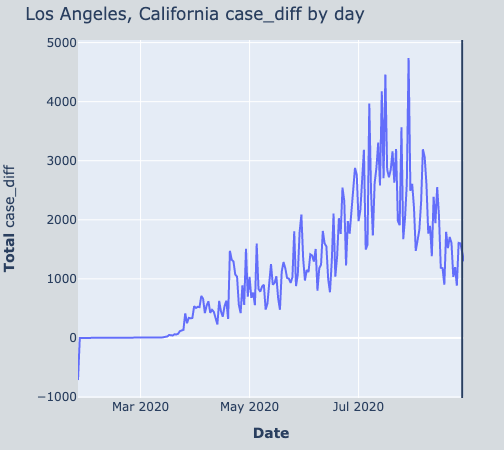

In [50]:
plotting.scatter_deaths_county(DF,'case_diff','2020-08-28','06037')

In [ ]:
DF['cases']

### Consistentcy Check

Here I want to check to see if we still have 30 nulls coming from fips codes. 

Since we're dealing with time series I want to check across all available dates to make sure we're consistent across all dates. Or at least that there is some sense as to why the data are missing.

First lets run a consistency check for one date. And create a function to check each specific date.

In [11]:
def check_null_fips(df, date, seen_set=set()):
    # Create a mask for a specific date.
    date_mask = (df['date'] == date)

    # Create a mask for when fips are null.
    fips_null_mask = (df['fips'].map(lambda x:len(x)) < 5)
    
    nulls_set = set(df[fips_null_mask & date_mask][['county','state']].apply(
        lambda x:str(x['county'])+str(x['state']), axis=1))
    
    # Print if find new
    if len(nulls_set.difference(seen_set.intersection(nulls_set))) != 0:
        print(f"{len(nulls_set.difference(seen_set.intersection(nulls_set)))} NEW nulls. {len(seen_set | nulls_set)} Total Unique Nulls on {date}")

    # Update seen_set
    seen_set = seen_set | nulls_set
    
    return seen_set #df[fips_null_mask & date_mask].shape[0]

# Test it out
a = check_null_fips(DF,'2020-08-28')

30 NEW nulls. 30 Total Unique Nulls on 2020-08-28


Here we see that we have 30 nulls, which is what we expected. Lets check across all dates now.

In [12]:
# 
sdate = date(2020, 3,1) # start date
edate = date(2020,8,28) # end date

date_list = [date.strftime(format="%Y-%m-%d") 
    for date in 
        pd.date_range(sdate, edate-timedelta(days=1), freq='d')]

In [13]:
# Create a list of sets seen
seen_set = set()

# Loop over date_list
for date in date_list:
    
    # First empty, then continues to grow
    seen_set = check_null_fips(DF, date, seen_set)

2 NEW nulls. 2 Total Unique Nulls on 2020-03-01
1 NEW nulls. 3 Total Unique Nulls on 2020-03-12
1 NEW nulls. 4 Total Unique Nulls on 2020-03-13
1 NEW nulls. 5 Total Unique Nulls on 2020-03-14
1 NEW nulls. 6 Total Unique Nulls on 2020-03-15
2 NEW nulls. 8 Total Unique Nulls on 2020-03-16
1 NEW nulls. 9 Total Unique Nulls on 2020-03-18
3 NEW nulls. 12 Total Unique Nulls on 2020-03-19
4 NEW nulls. 16 Total Unique Nulls on 2020-03-20
1 NEW nulls. 17 Total Unique Nulls on 2020-03-21
3 NEW nulls. 20 Total Unique Nulls on 2020-03-22
3 NEW nulls. 23 Total Unique Nulls on 2020-03-23
5 NEW nulls. 28 Total Unique Nulls on 2020-03-24
1 NEW nulls. 29 Total Unique Nulls on 2020-03-25
1 NEW nulls. 30 Total Unique Nulls on 2020-03-26
1 NEW nulls. 31 Total Unique Nulls on 2020-03-27
1 NEW nulls. 32 Total Unique Nulls on 2020-03-28
1 NEW nulls. 33 Total Unique Nulls on 2020-03-29
2 NEW nulls. 35 Total Unique Nulls on 2020-03-30
2 NEW nulls. 37 Total Unique Nulls on 2020-03-31
5 NEW nulls. 42 Total Uniqu

In [59]:
date_mask = (DF['date'] == '2020-08-28')

In [60]:
DF[date_mask]['cases']

476261    1389
476262    4347
476263     745
476264     535
476265    1219
          ... 
479489     296
479490     424
479491     292
479492     107
479493      18
Name: cases, Length: 3233, dtype: int64

In [61]:
import seaborn as sns

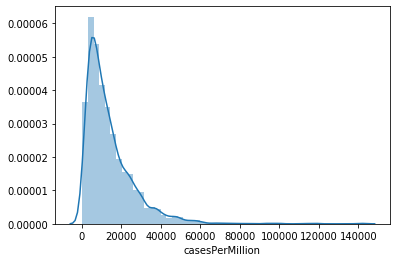

In [83]:
sns.distplot(DF[date_mask]['casesPerMillion'])

In [98]:
date_mask = (COVID_COUNTIES_DF['date'] == '2020-08-28')
category = 'cases'
category_series = COVID_COUNTIES_DF[date_mask][category]
print(f"Mean of {category} is {category_series.mean()}")
print(category_series.quantile([0, 0.1, 0.25, 0.5, 0.75, 0.8,0.85,0.9, 0.95, 0.99,1]))

Mean of cases is 1834.2978657593567
0.00         0.00
0.10        25.00
0.25        87.00
0.50       287.00
0.75       945.00
0.80      1294.20
0.85      1817.40
0.90      3238.60
0.95      7264.40
0.99     24515.92
1.00    238458.00
Name: cases, dtype: float64


In [64]:
DF[date_mask]['case_diff'].max()

238458

In [ ]:
date_mask = (COVID_COUNTIES_DF['date'] == '2020-03-01')

In [ ]:
DF